In [26]:
from torchdyn.core import NeuralODE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.utils.data as data
import torch.nn as nn
import pytorch_lightning as pl

In [27]:
device = torch.device("cuda:0")
torch.set_default_dtype(torch.float64)
torch.set_float32_matmul_precision("high")

In [28]:
def plot_l63(data, n, style="scatter"):
    if n > 0:
        data = data[:n, :]
    x, y, z = data.T
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    if style == "scatter":
        ax.scatter(x, y, z, s=1)
    elif style == "line":
        ax.plot(x, y, z, lw=0.3)
    else:
        raise ValueError
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"L63, {n} points")
    plt.show()

In [29]:
def get_loader(
    train_file: str,
    test_file: str,
    plot: bool = False,
    name: str = "",
    n_points: int = 1000,
    lag=1,
):
    traintensor = np.load(train_file)
    test = np.load(test_file)
    print(f"raw data shapes -- train: {traintensor.shape}, test: {test.shape}")
    X = torch.Tensor(traintensor[:-lag, :])
    Y = torch.Tensor(traintensor[lag:, :])
    print(f"train shapes -- x: {X.shape}, y: {Y.shape}")
    if plot and name == "l63":
        plot_l63(traintensor, n=n_points)
        plot_l63(traintensor, n=n_points, style="line")
    traintensor = data.TensorDataset(X, Y)
    trainloader = data.DataLoader(
        traintensor, batch_size=len(X), shuffle=True, num_workers=0
    )
    return trainloader

In [30]:
def get_loader_l63(plot=False, n_points=1000):
    return get_loader(
        train_file="lorenz63_on0.05_train.npy",
        test_file="lorenz63_test.npy",
        plot=plot,
        n_points=n_points,
        name="l63",
    )

In [31]:
def get_loader_l96():
    return get_loader(
        train_file="lorenz96_on0.05_train.npy",
        test_file="lorenz96_test.npy",
    )

In [32]:
class Learner_l63(pl.LightningModule):
    def __init__(self, t_span: torch.Tensor, model: nn.Module, lr: float):
        super().__init__()
        self.model, self.t_span = model, t_span
        self.trainloader = get_loader_l63()
        self.starting_lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1]  # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        print(f"loss: {loss}, lr: {self.optimizers().param_groups[0]['lr']}")
        self.log("loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.starting_lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "loss"}

    def train_dataloader(self):
        return self.trainloader

In [49]:
def get_model_l63():
    layers = [
        nn.Linear(3, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 3),
    ]
    f = nn.Sequential(*layers)
    model = NeuralODE(f, )
    # dopri5 works well for some reason
    # tsitouras45 is default but it sucks
    return model

In [59]:
model = Learner_l63(model=get_model_l63(), t_span=torch.linspace(0, 1, 3), lr=1e-2)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices="auto")
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 66.9 K | train
--------------------------------------------
66.9 K    Trainable params
0         Non-trainable params
66.9 K    Total params
0.268     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
raw data shapes -- train: (100000, 3), test: (100000, 3)
train shapes -- x: torch.Size([99999, 3]), y: torch.Size([99999, 3])


Training: |                                                                                                   …

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 7.65 GiB of which 80.38 MiB is free. Including non-PyTorch memory, this process has 7.55 GiB memory in use. Of the allocated memory 7.29 GiB is allocated by PyTorch, and 101.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [57]:
model(torch.Tensor([1,1,1]))[1].shape[0]

2

In [22]:
def iterate(model, start, n):
    x = torch.Tensor(start)
    traj = []
    with torch.no_grad():
        for _ in range(n):
            x = model(x)[1][-1, :]
            traj.append(x.numpy())
    return np.vstack(traj)

raw data shapes -- train: (100000, 3), test: (100000, 3)
train shapes -- x: torch.Size([99999, 3]), y: torch.Size([99999, 3])


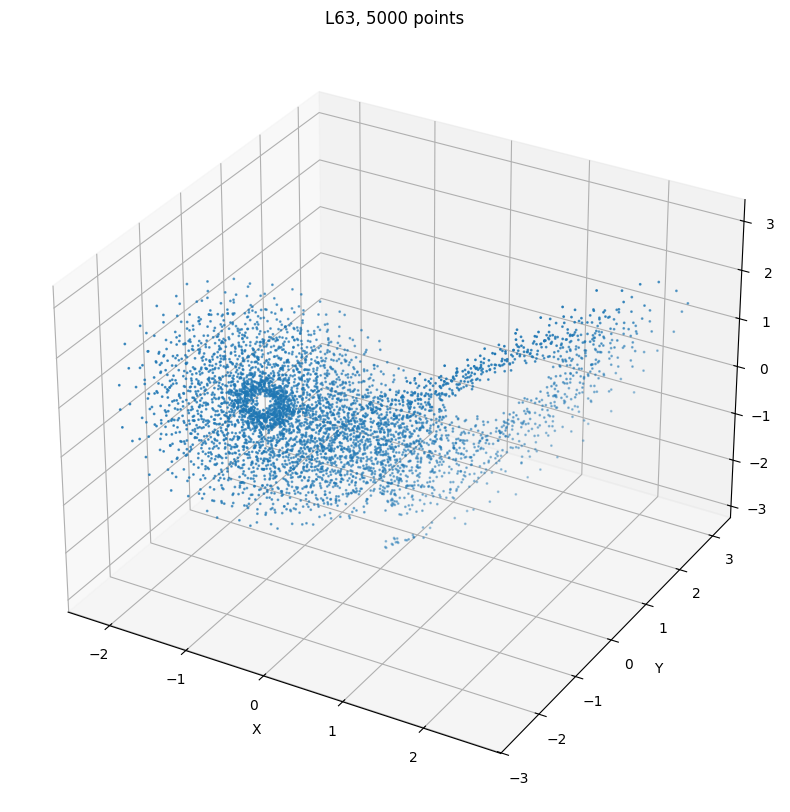

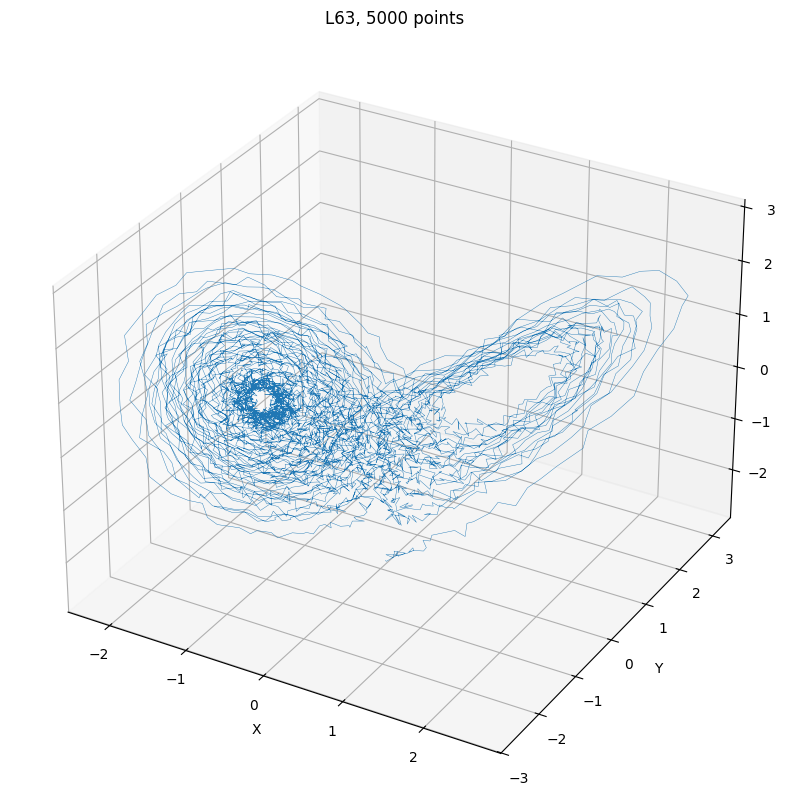

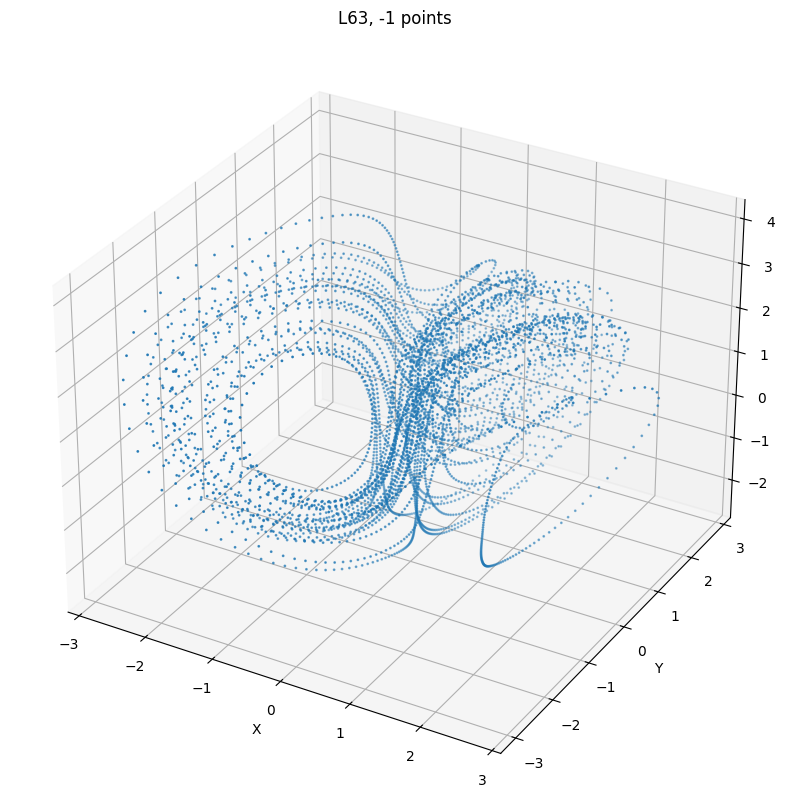

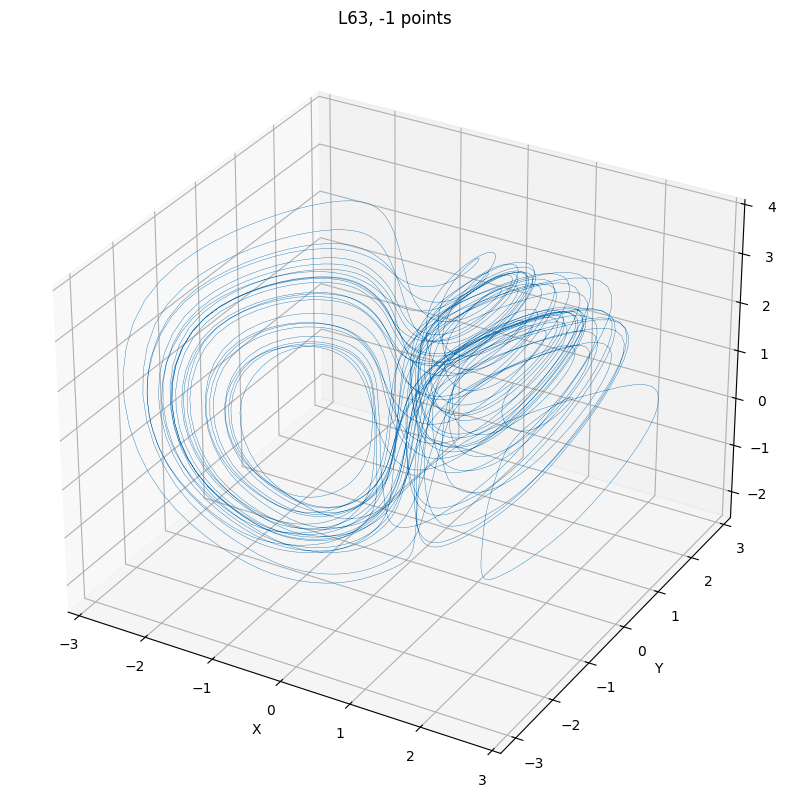

In [23]:
n_points = 5000
preds = iterate(model, [1, 1, 1], n_points)
get_loader_l63(True, n_points=n_points)
plot_l63(preds, -1, "scatter")
plot_l63(preds, -1, "line")